In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR,SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from copy import deepcopy
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

In [ ]:
DIR = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

In [ ]:
def one_hot_encoder(df):
  """
  one hot encoder.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: The one hot encoded dataframe.
  """
  for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
      one_hot = pd.get_dummies(df[col], prefix=f'{col}_', dtype=int)
      df = df.drop(col, axis=1)
      df = df.join(one_hot)
  return df

def generate_hour_one_hot(df):
  one_hot = pd.get_dummies(df['hour'].astype(str), prefix='hour_', dtype=int)
  df = df.drop('hour', axis=1)
  df = df.join(one_hot)
  return df

def generate_dayofweek_one_hot(df):
  one_hot = pd.get_dummies(df['dayofweek'].astype(str), prefix='dayofweek_', dtype=int)
  df = df.drop('dayofweek', axis=1)
  df = df.join(one_hot)
  return df

def generate_dayofyear_one_hot(df):
  one_hot = pd.get_dummies(df['dayofyear'].clip(upper=365).astype(str), prefix='dayofyear_', dtype=int)
  df = df.drop('dayofyear', axis=1)
  df = df.join(one_hot)
  return df

def setup_time(df):
  """
  setup time(utc=True) values to dataframe index.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: time indexed dataframe.
  """
  df['time'] = pd.to_datetime(df['time'], utc=True)
  df.set_index('time', inplace=True)
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  return df

def setup_dataframe(file):
  """
  setup dataframe.

  Args:
      file: csv file.

  Returns:
      pd.DataFrame: dataframe.
  """
  df = pd.read_csv(os.path.join(DIR, file))
  df = setup_time(df)
  #df = generate_hour_one_hot(df)
  #df = generate_dayofweek_one_hot(df)
  #df = generate_dayofyear_one_hot(df)
  df = one_hot_encoder(df)
  return df.fillna(0)

def one_hot_times(df):
  """
  one hot encoder.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: The one hot encoded dataframe.
  """
  df = generate_hour_one_hot(df)
  df = generate_dayofweek_one_hot(df)
  df = generate_dayofyear_one_hot(df)
  return df

In [ ]:
# prompt: 引数のdataframe(indexにdatetimeが設置済)にhour, dayofweek, dayofyearを追加、ただしdayofyearの上限は365

def add_time_features(df):
  """
  Add hour, dayofweek, and dayofyear features to a dataframe with a DatetimeIndex.

  Args:
      df (pd.DataFrame): The source dataframe with a DatetimeIndex.

  Returns:
      pd.DataFrame: The dataframe with added time features.
  """
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  #df = generate_hour_one_hot(df)
  #df = generate_dayofweek_one_hot(df)
  #df = generate_dayofyear_one_hot(df)

  return df

#HOUR_COLUMNS = [f'hour__{hour}' for hour in range(24)]
#DAYOFWEEK_COLUMNS = [f'dayofweek__{dayofweek}' for dayofweek in range(7)]
#DAYOFYEAR_COLUMNS = [f'dayofyear__{dayofyear}' for dayofyear in range(1,366)]

In [ ]:
train_df = setup_dataframe('train.csv')
test_df = setup_dataframe('test.csv')

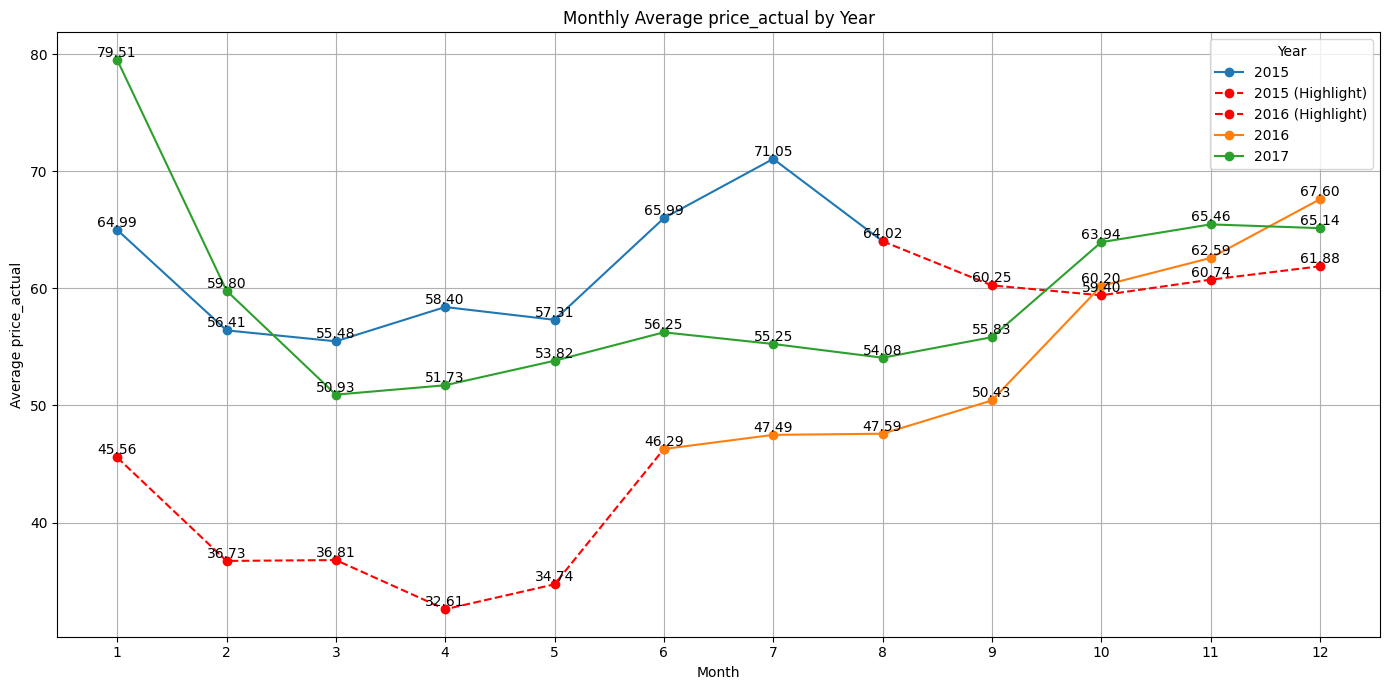

In [ ]:
# prompt: price_actualを年度ごとに系列化し1つのエリアに月平均の折れ線グラフを描画。
# x軸は1月～12月。
# y軸は月平均のprice_actual。
# 2015年の系列の08月～12月および2016年の1月～3月は線種を変えるか色を変えるかして強調すること。
# グラフ内にprice_actual月平均の数値は記述し読み取れるようエリアのサイズを調整すること。

import matplotlib.pyplot as plt
# price_actualを年度ごとに系列化し1つのエリアに月平均の折れ線グラフを描画
# x軸は1月～12月
# y軸は月平均のprice_actual

# 月と年の列を追加
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year

# 年ごとの月平均price_actualを計算
monthly_avg = train_df.groupby(['year', 'month'])['price_actual'].mean().reset_index()

# グラフの準備
plt.figure(figsize=(14, 7))

# 各年度の系列を描画
for year in monthly_avg['year'].unique():
    year_data = monthly_avg[monthly_avg['year'] == year].sort_values('month')

    # 2015年の8月～12月と2016年の1月～3月を強調
    if year == 2015:
        # 1月～7月
        data_before_highlight = year_data[(year_data['month'] >= 1) & (year_data['month'] <= 8)]
        if not data_before_highlight.empty:
            plt.plot(data_before_highlight['month'], data_before_highlight['price_actual'], marker='o', linestyle='-', label=f'{year}')

        # 8月～12月 (強調)
        data_highlight = year_data[(year_data['month'] >= 8) & (year_data['month'] <= 12)]
        if not data_highlight.empty:
            plt.plot(data_highlight['month'], data_highlight['price_actual'], marker='o', linestyle='--', color='red', label=f'{year} (Highlight)')

    elif year == 2016:
        # 1月～3月 (強調)
        data_highlight = year_data[(year_data['month'] >= 1) & (year_data['month'] <= 6)]
        if not data_highlight.empty:
            plt.plot(data_highlight['month'], data_highlight['price_actual'], marker='o', linestyle='--', color='red', label=f'{year} (Highlight)')

        # 4月～12月
        data_after_highlight = year_data[(year_data['month'] >= 6) & (year_data['month'] <= 12)]
        if not data_after_highlight.empty:
            plt.plot(data_after_highlight['month'], data_after_highlight['price_actual'], marker='o', linestyle='-', label=f'{year}')

    else:
        # その他の年度
        plt.plot(year_data['month'], year_data['price_actual'], marker='o', linestyle='-', label=f'{year}')

# グラフの設定
plt.title('Monthly Average price_actual by Year')
plt.xlabel('Month')
plt.ylabel('Average price_actual')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)

# 数値をプロット
for year in monthly_avg['year'].unique():
    year_data = monthly_avg[monthly_avg['year'] == year].sort_values('month')
    for index, row in year_data.iterrows():
        plt.text(row['month'], row['price_actual'], f'{row["price_actual"]:.2f}', ha='center', va='bottom')

# グラフエリアのサイズ調整
plt.tight_layout()
plt.show()

In [ ]:
# prompt: train_dfの数値項目を対象に年,月ごとのprice_actualとの相関係数(spearman)のデータフレームを作成

train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'price_actual', 'year', and 'month' from the numeric columns for correlation calculation against 'price_actual'
numeric_cols_for_corr = [col for col in numeric_cols if col not in ['price_actual', 'year', 'month', 'hour', 'dayofyear', ]]

# Create an empty dictionary to store the correlation dataframes
monthly_yearly_correlations = {}

# Iterate through each numeric column (excluding 'price_actual', 'year', 'month')
for col in numeric_cols_for_corr:
    # Calculate the Spearman correlation for each year and month
    corr_df = train_df.groupby(['year', 'month'])[[col, 'price_actual']].corr(method='spearman').unstack().iloc[:, 1].unstack()
    monthly_yearly_correlations[col] = corr_df

# Combine the correlation dataframes into a single dataframe
# This will be a MultiIndex dataframe where the outer index is the column name
# and the inner index is the year and month
correlation_summary_df = pd.concat(monthly_yearly_correlations, axis=0)

# Display the resulting dataframe
correlation_summary_df.fillna(0, inplace=True)
correlation_summary_df_abs = correlation_summary_df.abs()

corr_mean_val = correlation_summary_df_abs.mean()
corr_std_val = correlation_summary_df_abs.std(ddof=0)

# Calculate the threshold: mean + 2 * std
target_threshold_2std = corr_mean_val + 2.0 * corr_std_val

# Identify data points where the absolute correlation is greater than the threshold in any month
# We use .stack() to make it easier to filter based on values
anomalous_correlations = correlation_summary_df_abs[correlation_summary_df_abs > target_threshold_2std].stack().reset_index()

print("Data points where absolute correlation is greater than mean + 2*std in any month:")
FEATURES = anomalous_correlations['level_0'].unique()
FEATURES = [column for column in FEATURES if column not in ['price_actual', 'year', 'month', 'hour', 'dayofyear', 'dayofweek']]
#FEATURES

Data points where absolute correlation is greater than mean + 2*std in any month:


In [ ]:
GENERATION_FEATURES = [column for column in FEATURES if column.startswith('generation')]
WEATHER_FEATURES = [column for column in FEATURES if column not in GENERATION_FEATURES]

In [ ]:
# prompt: GENERATION_FEATURESに定義された項目でPCAを取得

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# PCAモデルの初期化 (コンポーネント数を指定しない場合は、特徴量の数になる)
pca_generation = PCA(n_components=3, random_state=42)
pca_weather = PCA(n_components=5, random_state=42)
pca_all = PCA(n_components=8, random_state=42)

# データを変換
principal_components_g = pca_generation.fit_transform(train_df[GENERATION_FEATURES])
principal_components_w = pca_weather.fit_transform(train_df[WEATHER_FEATURES])
principal_components_a = pca_all.fit_transform(train_df[GENERATION_FEATURES + WEATHER_FEATURES])

def calculate_vector_norm_ratio(vec1: np.ndarray, vec2: np.ndarray) -> float:
  """
  Calculate the ratio of the norms of two vectors.

  Args:
      vec1 (np.ndarray): The first input vector.
      vec2 (np.ndarray): The second input vector.

  Returns:
      float: The ratio of the norm of vec1 to the norm of vec2.
             Returns 0 if the norm of vec2 is zero to avoid division by zero.
  """
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm2 == 0:
    return 0.0
  else:
    return norm1 / norm2

def calculate_cossim(vec1: np.ndarray, vec2: np.ndarray) -> float:
  """
  Calculate the cosine similarity between two vectors.

  Args:
      vec1 (np.ndarray): The first input vector.
      vec2 (np.ndarray): The second input vector.

  Returns:
      float: The cosine similarity between the two vectors.
  """
  # Reshape vectors for cosine_similarity function if they are 1D
  vec1 = vec1.flatten()
  vec2 = vec2.flatten()

  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def generation_feature_relations(x,pca=pca_generation):
  """
  Calculate relations between generation features using PCA.

  Args:
      x (np.ndarray): vector of generation features.

  Returns:
      cosine_similarity (float): The cosine similarity between two vectors.
      vector_norm_ratio (float): The ratio of the norms of two vectors.
      principal_components_1 (first): The principal components of the input vector.
      principal_components_2 (second): The principal components of the input vector.
      principal_components_3 (third): The principal components of the input vector.
  """
  x_trans = pca.transform([x])
  x_inv = pca.inverse_transform(x_trans)
  cosine_similarity_value = calculate_cossim(x.values, x_inv)
  vector_norm_ratio_value = calculate_vector_norm_ratio(x, x_inv)
  return cosine_similarity_value, vector_norm_ratio_value,x_trans[0][0],x_trans[0][1],x_trans[0][2]

def weather_feature_relations(x,pca=pca_weather):
  """
  Calculate relations between weather features using PCA.

  Args:
      x (np.ndarray): vector of waether features.

  Returns:
      cosine_similarity (float): The cosine similarity between two vectors.
      vector_norm_ratio (float): The ratio of the norms of two vectors.
      principal_components_1 (first): The principal components of the input vector.
      principal_components_2 (second): The principal components of the input vector.
      principal_components_3 (third): The principal components of the input vector.
      principal_components_4 (4-th): The principal components of the input vector.
      principal_components_5 (5-th): The principal components of the input vector.
  """
  x_trans = pca.transform([x])
  x_inv = pca.inverse_transform(x_trans)
  cosine_similarity_value = calculate_cossim(x.values, x_inv)
  vector_norm_ratio_value = calculate_vector_norm_ratio(x, x_inv)
  return cosine_similarity_value, vector_norm_ratio_value,x_trans[0][0],x_trans[0][1],x_trans[0][2],x_trans[0][3],x_trans[0][4]

def all_feature_relations(x,pca=pca_all):
  """
  Calculate relations between all features using PCA.

  Args:
      x (np.ndarray): vector of all features.

  Returns:
      cosine_similarity (float): The cosine similarity between two vectors.
      vector_norm_ratio (float): The ratio of the norms of two vectors.
      principal_components_1 (first): The principal components of the input vector.
      principal_components_2 (second): The principal components of the input vector.
      principal_components_3 (third): The principal components of the input vector.
      principal_components_4 (4-th): The principal components of the input vector.
      principal_components_5 (5-th): The principal components of the input vector.
      principal_components_5 (6-th): The principal components of the input vector.
      principal_components_5 (7-th): The principal components of the input vector.
      principal_components_5 (8-th): The principal components of the input vector.
  """
  x_trans = pca.transform([x])
  x_inv = pca.inverse_transform(x_trans)
  cosine_similarity_value = calculate_cossim(x.values, x_inv)
  vector_norm_ratio_value = calculate_vector_norm_ratio(x, x_inv)
  return cosine_similarity_value, vector_norm_ratio_value,x_trans[0][0],x_trans[0][1],x_trans[0][2],x_trans[0][3],x_trans[0][4],x_trans[0][5],x_trans[0][6],x_trans[0][7]


# Principal components を DataFrame に変換
principal_g_df = train_df[GENERATION_FEATURES].apply(lambda x: generation_feature_relations(x), axis=1)
principal_g_df = pd.DataFrame({'g_cosine_similarity': [x[0] for x in principal_g_df],
                             'g_vector_norm_ratio': [x[1] for x in principal_g_df],
                              'pc_g_1': [x[2] for x in principal_g_df],
                              'pc_g_2': [x[3] for x in principal_g_df],
                              'pc_g_3': [x[4] for x in principal_g_df],
                             }, index=train_df.index)
principal_w_df = train_df[WEATHER_FEATURES].apply(lambda x: weather_feature_relations(x), axis=1)
principal_w_df = pd.DataFrame({'w_cosine_similarity': [x[0] for x in principal_w_df],
                             'w_vector_norm_ratio': [x[1] for x in principal_w_df],
                              'pc_w_1': [x[2] for x in principal_w_df],
                              'pc_w_2': [x[3] for x in principal_w_df],
                              'pc_w_3': [x[4] for x in principal_w_df],
                              'pc_w_4': [x[5] for x in principal_w_df],
                              'pc_w_5': [x[6] for x in principal_w_df],
                             }, index=train_df.index)
principal_a_df = train_df[GENERATION_FEATURES + WEATHER_FEATURES].apply(lambda x: all_feature_relations(x), axis=1)
principal_a_df = pd.DataFrame({'a_cosine_similarity': [x[0] for x in principal_a_df],
                             'a_vector_norm_ratio': [x[1] for x in principal_a_df],
                              'pc_a_1': [x[2] for x in principal_a_df],
                              'pc_a_2': [x[3] for x in principal_a_df],
                              'pc_a_3': [x[4] for x in principal_a_df],
                              'pc_a_4': [x[5] for x in principal_a_df],
                              'pc_a_5': [x[6] for x in principal_a_df],
                              'pc_a_6': [x[7] for x in principal_a_df],
                              'pc_a_7': [x[8] for x in principal_a_df],
                              'pc_a_8': [x[9] for x in principal_a_df],
                             }, index=train_df.index)

# 元のDataFrameに結合することもできます
train_df_pca = pd.concat([train_df, principal_g_df, principal_w_df, principal_a_df], axis=1)

principal_g_df_test = test_df[GENERATION_FEATURES].apply(lambda x: generation_feature_relations(x), axis=1)
principal_g_df_test = pd.DataFrame({'g_cosine_similarity': [x[0] for x in principal_g_df_test],
                                  'g_vector_norm_ratio': [x[1] for x in principal_g_df_test],
                                  'pc_g_1': [x[2] for x in principal_g_df_test],
                                  'pc_g_2': [x[3] for x in principal_g_df_test],
                                  'pc_g_3': [x[4] for x in principal_g_df_test],
                                  }, index=test_df.index)
principal_w_df_test = test_df[WEATHER_FEATURES].apply(lambda x: weather_feature_relations(x), axis=1)
principal_w_df_test = pd.DataFrame({'w_cosine_similarity': [x[0] for x in principal_w_df_test],
                                  'w_vector_norm_ratio': [x[1] for x in principal_w_df_test],
                                  'pc_w_1': [x[2] for x in principal_w_df_test],
                                  'pc_w_2': [x[3] for x in principal_w_df_test],
                                  'pc_w_3': [x[4] for x in principal_w_df_test],
                                  'pc_w_4': [x[5] for x in principal_w_df_test],
                                  'pc_w_5': [x[6] for x in principal_w_df_test],
                                  }, index=test_df.index)
principal_a_df_test = test_df[GENERATION_FEATURES + WEATHER_FEATURES].apply(lambda x: all_feature_relations(x), axis=1)
principal_a_df_test = pd.DataFrame({'a_cosine_similarity': [x[0] for x in principal_a_df_test],
                             'a_vector_norm_ratio': [x[1] for x in principal_a_df_test],
                              'pc_a_1': [x[2] for x in principal_a_df_test],
                              'pc_a_2': [x[3] for x in principal_a_df_test],
                              'pc_a_3': [x[4] for x in principal_a_df_test],
                              'pc_a_4': [x[5] for x in principal_a_df_test],
                              'pc_a_5': [x[6] for x in principal_a_df_test],
                              'pc_a_6': [x[7] for x in principal_a_df_test],
                              'pc_a_7': [x[8] for x in principal_a_df_test],
                              'pc_a_8': [x[9] for x in principal_a_df_test],
                             }, index=test_df.index)

test_df_pca = pd.concat([test_df, principal_g_df_test, principal_w_df_test, principal_a_df_test], axis=1)

In [ ]:
pca_all.explained_variance_/pca_all.explained_variance_.sum()

array([0.83194612, 0.08874662, 0.0426195 , 0.01508225, 0.00965871,
       0.00706958, 0.00302708, 0.00185015])

In [ ]:
EXPLANATORY_VARIABLES = ['pc_a_1', 'pc_a_2', 'pc_a_3', ] + ['hour', 'dayofweek', 'dayofyear']

# Example usage:
# Assuming you have a DataFrame 'df' with a DatetimeIndex
train_df_with_pca_and_time_features = add_time_features(train_df_pca)[EXPLANATORY_VARIABLES]
test_df_with_pca_and_time_features = add_time_features(test_df_pca)[EXPLANATORY_VARIABLES]

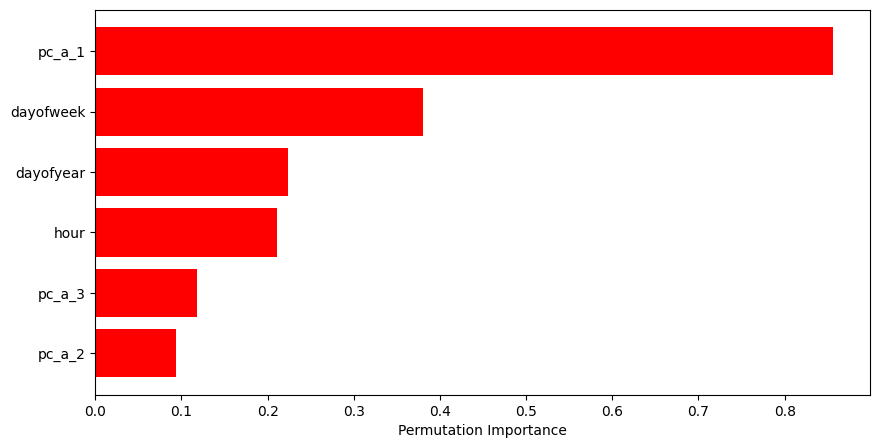

In [ ]:
model = make_pipeline(MinMaxScaler(),TransformedTargetRegressor(SVR(kernel='rbf'), transformer=StandardScaler()))

X = train_df_with_pca_and_time_features.iloc[:1000]
y = train_df['price_actual'].iloc[:1000]
model.fit(X, y)
result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=2)
plt.figure(figsize=(10, 5))
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X.shape[1]), result.importances_mean[sorted_idx], color="r", align="center")
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
from scipy.fft import fft, fftfreq

WINDOW_SIZE = 24 * 14

def calculate_fft_amplitude(data: np.ndarray, window_size=WINDOW_SIZE) -> tuple[np.ndarray, np.ndarray]:
    """
    FFT (高速フーリエ変換) を利用して、時系列データの周波数と振幅を算出します。

    Args:
        data (np.ndarray): FFTを適用する数値データの配列 (1次元)。
                           サンプル数は140と想定。
        window_size (int): ウィンドウサイズ。

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - frequencies (np.ndarray): 算出した周波数の配列。
            - amplitudes (np.ndarray): 算出した振幅の配列。
    """
    n = len(data) # サンプル数
    if n != window_size:
        print(f"Warning: Input data length is {n}, but {window_size} is expected.")

    # FFTを実行
    yf = fft(data)

    # サンプリング周波数 (ここでは時間の粒度を1日とするので、サンプリング周波数は1/日)
    # 時系列データが日ごとのデータ (resample('D')) なので、1日あたりのサンプリング間隔は1
    # サンプリング周波数は 1 / サンプリング間隔 = 1 / 1 = 1 (日^-1)
    # もし元のデータが1時間ごとなら、サンプリング間隔は1/24日なので、サンプリング周波数は24 (日^-1) になります。
    # ここでは日ごとのデータなので、サンプリング周波数は1とします。
    # f_s = 1.0 # 1日あたりのサンプリング周波数

    # サンプリング間隔 (ここでは1日)
    T = 1.0

    # 周波数を算出
    # fftfreqの第2引数はサンプリング間隔 (1/サンプリング周波数) です。
    frequencies = fftfreq(n, T)

    # 振幅を算出 (ナイキスト周波数までの片側スペクトル)
    # 複素数の振幅の絶対値を取り、正規化（サンプル数nで割る）し、
    # 交流成分は実部と虚部の2箇所に出るため2倍します。
    # 直流成分 (周波数0) は2倍しません。
    amplitudes = 2.0/n * np.abs(yf[0:n//2])
    frequencies = frequencies[0:n//2] # 周波数もナイキスト周波数まで

    return frequencies, amplitudes

def get_extracted_data(daily_df, window_size=WINDOW_SIZE):
  """
  指定されたwindow_sizeで1ステップづつシフトしたwindowを作成します。
  作成するwindowは未来データへのリークにならないよう日時tを基準として
  t以前の説明変数をパッケージングします。

  Args:
      daily_df (pd.DataFrame) : sourceデータ
      window_size (int): ウィンドウサイズ。

  Returns:
      [ (t : datetime, window : pd.DataFrame) ]:

          - t : windowの日時。
          - window : windowデータ。
  """

  extracted_data = []

  # price_actual_dailyは日ごとのデータなので、インデックスは日付です。
  # 抽出を開始する最初のインデックスから最後のインデックスまでループします。
  # 最後のインデックスは、ウィンドウサイズを考慮して決定します。
  for start_index in range(len(daily_df)):
    # 開始インデックスからウィンドウサイズ分のデータをスライス
    # ilocを使用して位置ベースで抽出します。
    extracted_window = daily_df.iloc[start_index : start_index + window_size]
    if len(extracted_window) < window_size:
      break
    # 抽出したウィンドウを配列に格納
    # DataFrameのまま格納することも、値をNumPy配列として格納することも可能です。
    # ここではDataFrameとして格納します。
    # 抽出したウィンドウを配列に格納
    # DataFrameのまま格納することも、値をNumPy配列として格納することも可能です。
    # ここではDataFrameとして格納します。
    extracted_data.append((extracted_window.index[-1], extracted_window))
  return extracted_data

def zero_crossing_median(values):
  """
  Calculate zero-crossings around the median of a list of numbers.

  Args:
      values (list or np.ndarray): A list or array of numerical data.

  Returns:
      int: The number of times the data crosses the median value.
  """
  if len(values) < 2:
    return 0

  # Calculate the median of the data
  median_value = np.median(values)

  # Shift the data by subtracting the median
  shifted_values = values - median_value

  # Find where the shifted values change sign
  # The sign change indicates a crossing of the original median
  sign_changes = np.diff(np.sign(shifted_values))

  # Count the number of non-zero entries in sign_changes.
  # A non-zero entry means a sign change occurred (crossing the median).
  zero_crossings = np.sum(sign_changes != 0)

  return zero_crossings


def get_fft_date(extracted_data, columns):
  """
  指定されたwindow_sizeで1ステップづつシフトしたwindowを作成します。

  Args:
      extracted_data ([pd.DataFrame]) : window_sizeで切り出されたwindowの配列。
      columns (list): fftを適用するカラムのリスト。

  Returns:
      fft_results (dict) : fft結果の辞書。キーはカラム。値はfft結果のDataFrame。

  """
  fft_results = {}
  for column in columns:
    amplitudes_data =[]
    index_data=[]
    stats_data = []
    for t, window_df in extracted_data:
      # price_actualの平均値の列 (price_actual_mean_daily) を使用
      data_to_fft = window_df[column].values
      data_min = window_df[column].min()
      data_max = window_df[column].max()
      data_mean = window_df[column].mean()
      data_std = window_df[column].std()
      data_zc = zero_crossing_median(window_df[column].values)

      # 欠損値が含まれている場合はスキップまたは補間などの処理が必要です。
      # ここでは欠損値がないと仮定します。
      if not np.isnan(data_to_fft).any():
        frequencies, amplitudes = calculate_fft_amplitude(data_to_fft)
        amplitudes_data.append(amplitudes)
        index_data.append(t)
        stats_data.append([data_min, data_max, data_mean, data_std, data_zc])
        #fft_results.append({'frequencies': frequencies, 'amplitudes': amplitudes, 'start_date': window_df.index[0], 'end_date' : window_df.index[-1]})
      else:
        print(f"Skipping window starting {window_df.index[0]} due to missing values.")
    amp_df = pd.DataFrame(amplitudes_data, index=index_data)
    stats_df = pd.DataFrame(stats_data, index=index_data, columns=['min', 'max', 'mean', 'std', 'zc'])
    fft_results[column] = amp_df.join(stats_df)
  return fft_results

def fft_correlation_by_column(fft_results, columns):
  """
  周波数成分とprice_actualとの相関をカラムごとに出力します。

  Args:
      fft_results(dict) : fft結果の辞書。キーはカラム。値はfft結果のDataFrame。
      columns (list): fftを適用するカラムのリスト。

  Returns:
      fft_corr_dict(dict) : 周波数成分とprice_actualとの相関を格納した辞書。

  """
  fft_corr_dict = {}
  for column in columns:
    fft_result = fft_results[column]
    fft_result = fft_result.join(train_df['price_actual'])
    fft_result_corr = pd.DataFrame({'price_actual':fft_result.corr(method='spearman')['price_actual']})
    fft_result_corr['abs_price_actual'] = fft_result_corr['price_actual'].abs()
    fft_result_corr = fft_result_corr[~fft_result_corr.index.isin(['price_actual'])]
    fft_corr_dict[column] = fft_result_corr
  return fft_corr_dict


def create_fft_correlation(daily_df, columns,is_train=True):
  """
  周波数成分とprice_actualとの相関辞書を作成します。
  キー : カラム
  値 : 周波数成分とprice_actualとの相関のDataFrame

  Args:
      daily_df : pd.DataFrame
      columns (list): fftを適用するカラムのリスト。
      is_train (bool): 学習データかどうか。

  Returns:
      fft_corr_dict(dict) : 周波数成分とprice_actualとの相関を格納した辞書。
      fft_results(dict) : fft結果の辞書。キーはカラム。値はfft結果のDataFrame。

  """
  extracted_data = get_extracted_data(daily_df)
  fft_results = get_fft_date(extracted_data, columns)
  if is_train:
    fft_corr_dict = fft_correlation_by_column(fft_results, columns)
  else:
    fft_corr_dict = None
  return fft_corr_dict, fft_results

def select_column(fft_corr_dict, z_score_threshold = 1.5):
  """
  price_actualとの相関の高いカラムを抽出します。

  Args:
      fft_corr_dict(dict) : 周波数成分とprice_actualとの相関を格納した辞書。
      z_score_threshold(float) : 抽出対象のz_scoreの閾値。

  Returns:
      values(pd.DataFrame) : z_scoreの閾値を超える周波数成分,カラムなどの情報。
  """

  values=[]
  for key, value in fft_corr_dict.items():
    value = value.copy()
    value['column'] = key
    value['index'] = value.index
    values.append(value)

  values = pd.concat(values, ignore_index=True)
  mean_val = values['abs_price_actual'].mean()
  std_val = values['abs_price_actual'].std()
  values['z_score'] = (values['abs_price_actual'] - mean_val) / std_val
  return values[values['z_score']>z_score_threshold]

def extract_by_select_column(select_column_df, fft_data):
  """
  カラム情報をもとにfftデータを抽出する。

  Args:
      select_column_df(pd.DataFrame) : z_scoreの閾値を超える周波数成分,カラムなどの情報。
      fft_data(pd.DataFrame) : fft結果のDataFrame
  Returns:
      extracted(pd.DataFrame) : 抽出したDataFrame
  """
  extracted = {}
  for column, index in zip(select_column_df['column'], select_column_df['index']):
    key = f"{column}_{index}"
    extracted[key] = fft_data[column][index]
  return pd.DataFrame(extracted)

In [ ]:
all_df = pd.concat([train_df[FEATURES], test_df[FEATURES]], ignore_index=False).sort_index()
test_start_pos = len(train_df) - WINDOW_SIZE + 1
train_for_stats = all_df.iloc[:len(train_df)].copy()
test_for_stats = all_df.iloc[test_start_pos:].copy()

In [ ]:
train_for_stats.tail(), test_for_stats.head()

(                           generation_biomass  \
 time                                            
 2017-12-31 18:00:00+00:00               286.0   
 2017-12-31 19:00:00+00:00               282.0   
 2017-12-31 20:00:00+00:00               284.0   
 2017-12-31 21:00:00+00:00               280.0   
 2017-12-31 22:00:00+00:00               290.0   
 
                            generation_fossil_brown_coal/lignite  \
 time                                                              
 2017-12-31 18:00:00+00:00                                   0.0   
 2017-12-31 19:00:00+00:00                                   0.0   
 2017-12-31 20:00:00+00:00                                   0.0   
 2017-12-31 21:00:00+00:00                                   0.0   
 2017-12-31 22:00:00+00:00                                   0.0   
 
                            generation_fossil_gas  generation_fossil_hard_coal  \
 time                                                                            
 2017-

In [ ]:
# 学習に使う特徴量を選定

fft_corr, fft_data_train = create_fft_correlation(train_for_stats, FEATURES)
_, fft_data_test = create_fft_correlation(test_for_stats, FEATURES, is_train=False)
selected_df = select_column(fft_corr,2.0)[['column','index']]

In [ ]:
train_extracted_fft_df = extract_by_select_column(selected_df, fft_data_train)
test_extracted_fft_df = extract_by_select_column(selected_df, fft_data_test)
train_extracted_fft_df.tail(), test_extracted_fft_df.head()

(                           generation_biomass_zc  \
 2017-12-31 18:00:00+00:00                      9   
 2017-12-31 19:00:00+00:00                     11   
 2017-12-31 20:00:00+00:00                     13   
 2017-12-31 21:00:00+00:00                     13   
 2017-12-31 22:00:00+00:00                      9   
 
                            generation_fossil_brown_coal/lignite_0  \
 2017-12-31 18:00:00+00:00                              978.005952   
 2017-12-31 19:00:00+00:00                              976.160714   
 2017-12-31 20:00:00+00:00                              974.214286   
 2017-12-31 21:00:00+00:00                              972.386905   
 2017-12-31 22:00:00+00:00                              970.625000   
 
                            generation_fossil_brown_coal/lignite_42  \
 2017-12-31 18:00:00+00:00                                12.727345   
 2017-12-31 19:00:00+00:00                                14.458246   
 2017-12-31 20:00:00+00:00                   

In [ ]:
test_extracted_fft_df.shape, train_extracted_fft_df.shape

((8760, 767), (25945, 767))

In [ ]:
train_all = train_extracted_fft_df
test_all = test_extracted_fft_df
train_all.tail(), test_all.head()

(                           generation_biomass_zc  \
 2017-12-31 18:00:00+00:00                      9   
 2017-12-31 19:00:00+00:00                     11   
 2017-12-31 20:00:00+00:00                     13   
 2017-12-31 21:00:00+00:00                     13   
 2017-12-31 22:00:00+00:00                      9   
 
                            generation_fossil_brown_coal/lignite_0  \
 2017-12-31 18:00:00+00:00                              978.005952   
 2017-12-31 19:00:00+00:00                              976.160714   
 2017-12-31 20:00:00+00:00                              974.214286   
 2017-12-31 21:00:00+00:00                              972.386905   
 2017-12-31 22:00:00+00:00                              970.625000   
 
                            generation_fossil_brown_coal/lignite_42  \
 2017-12-31 18:00:00+00:00                                12.727345   
 2017-12-31 19:00:00+00:00                                14.458246   
 2017-12-31 20:00:00+00:00                   

In [ ]:
train_all.shape, test_all.shape

((25945, 767), (8760, 767))

In [ ]:
pca_timeseries = PCA(n_components=10)
pca_timeseries.fit(train_all)
pca_timeseries.explained_variance_/pca_timeseries.explained_variance_.sum()

array([0.57126409, 0.23499794, 0.08464877, 0.04900641, 0.022342  ,
       0.01305585, 0.01232788, 0.00700626, 0.00275038, 0.0026004 ])

In [ ]:
time_series_pca_columns = [f'pca_{i}' for i in range(10)]
train_extracted_pca = pca_timeseries.transform(train_all)
train_all = pd.DataFrame(train_extracted_pca, index=train_all.index, columns=time_series_pca_columns)
train_all = add_time_features(train_all)
test_extracted_pca = pca_timeseries.transform(test_all)
test_all = pd.DataFrame(test_extracted_pca, index=test_all.index, columns=time_series_pca_columns)
test_all = add_time_features(test_all)
train_all.head(), test_all.head()

(                                pca_0       pca_1       pca_2        pca_3  \
 2015-01-15 22:00:00+00:00 -824.326110  232.266691  473.666362  1606.575116   
 2015-01-15 23:00:00+00:00 -825.070104  234.999789  483.393387  1608.462224   
 2015-01-16 00:00:00+00:00 -825.291938  233.823524  490.121090  1609.898775   
 2015-01-16 01:00:00+00:00 -825.460874  232.364138  493.362436  1609.226824   
 2015-01-16 02:00:00+00:00 -825.661968  231.871336  495.933589  1610.443631   
 
                                  pca_4        pca_5      pca_6        pca_7  \
 2015-01-15 22:00:00+00:00 -3350.166112 -1167.567833 -80.630979 -1127.815736   
 2015-01-15 23:00:00+00:00 -3356.290227 -1163.878613 -81.834844 -1127.214908   
 2015-01-16 00:00:00+00:00 -3363.517539 -1158.813007 -83.712907 -1127.629514   
 2015-01-16 01:00:00+00:00 -3369.258044 -1154.927280 -85.065888 -1126.924602   
 2015-01-16 02:00:00+00:00 -3371.903583 -1152.955143 -85.573279 -1127.347865   
 
                                 pca_8    

In [ ]:
EXPLANATORY_VARIABLES = ['pca_0', 'pca_1', 'pca_2', 'pca_3','pca_4','pca_5','pca_6', ]
X = train_all[EXPLANATORY_VARIABLES].join(train_df_with_pca_and_time_features)
y = train_df[train_df.index.isin(X.index)]['price_actual']
len(X), len(y)

(25945, 25945)

In [ ]:
# prompt: X, yをSVRでクロスバリデーション,評価はR2,RMSE,MAE
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import NuSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
# Define the number of folds for cross-validation
n_splits = 4
kf = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation results
r2_scores = []
rmse_scores = []
mae_scores = []

models = []

# Create the SVR model
model = make_pipeline(MinMaxScaler(),TransformedTargetRegressor(SVR(kernel='rbf'), transformer=StandardScaler()))

IMPORTANT_COLUMNS = ['pca_1', 'pca_2', 'pca_3','pca_4','pca_5', 'hour', 'dayofweek', 'dayofyear', 'pc_a_1', 'pc_a_2', 'pc_a_3']

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
  print(f"Fold {fold+1}/{n_splits}")

  X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  # Train the model
  model.fit(X_train, y_train)
  models.append(deepcopy(model))
  # Make predictions on the validation set
  y_pred = model.predict(X_val)

  # Evaluate the model
  r2 = r2_score(y_val, y_pred)
  rmse = root_mean_squared_error(y_val, y_pred) # squared=False for RMSE
  mae = mean_absolute_error(y_val, y_pred)

  print(f"  R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, start : {y_val.index.date[0]}, end : {y_val.index.date[-1]}")

  r2_scores.append(r2)
  rmse_scores.append(rmse)
  mae_scores.append(mae)

# Print the average evaluation scores across all folds
print("\n--- Average Scores ---")
print(f"Average R2: {np.mean(r2_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")

Fold 1/4
  R2: 0.2644, RMSE: 13.0296, MAE: 9.8627, start : 2015-08-20, end : 2016-03-23
Fold 2/4
  R2: -0.3293, RMSE: 12.6953, MAE: 10.8281, start : 2016-03-23, end : 2016-10-25
Fold 3/4
  R2: -0.1378, RMSE: 14.6696, MAE: 11.1838, start : 2016-10-25, end : 2017-05-29
Fold 4/4
  R2: -0.0732, RMSE: 10.4619, MAE: 8.3638, start : 2017-05-29, end : 2017-12-31

--- Average Scores ---
Average R2: -0.0690
Average RMSE: 12.7141
Average MAE: 10.0596


In [ ]:
sample_submit = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'),header=None, names=['time','y_pred'])
test = test_all[EXPLANATORY_VARIABLES].join(test_df_with_pca_and_time_features)[IMPORTANT_COLUMNS]
y_pred = models[0].predict(test)
sample_submit['y_pred'] = y_pred
sample_submit.to_csv(os.path.join(DIR,'submit_svr_pca_v6.csv'), index=False, header=None)
sample_submit.head(),sample_submit.describe()

(                        time     y_pred
 0  2018-01-01 00:00:00+01:00  56.197298
 1  2018-01-01 01:00:00+01:00  39.964684
 2  2018-01-01 02:00:00+01:00  39.768008
 3  2018-01-01 03:00:00+01:00  40.419309
 4  2018-01-01 04:00:00+01:00  41.694771,
             y_pred
 count  8760.000000
 mean     63.368172
 std       9.948395
 min      31.727221
 25%      57.096595
 50%      63.877044
 75%      70.224465
 max      87.406879)